In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import pandas as pd
import numpy as np
import torchvision
import cv2
import pytorch_lightning as pl
import torchmetrics as tm

from torch.utils.data import Dataset, DataLoader
from ZeroShotDataset import ZeroShotDataset
from params import *
from transformers import CLIPProcessor, CLIPModel
from LossFunc import *
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from torch.utils.data import random_split
from CLIPConditionedSegFormerModel import CLIPConditionedSegFormer

In [4]:
prueba_df = pd.read_csv('test_results.csv')
print(prueba_df)
hiou = H_IoULoss()
print(hiou(prueba_df['iou'][0], prueba_df['iou'][1]))
# test_df.to_csv('test_results.csv', index=False)

     test       acc      dice       iou        f1
0  Unseen  0.825741  0.607357  0.303705  0.825741
1    Seen  0.843713  0.720149  0.196095  0.843713
2     All  0.842898  0.710173  0.205728  0.842898
0.2383156333424745


In [2]:
tests_params = {
    'Unseen' : {
        'filter_unseen' : True,
        'filter_seen' : False
    },
    'Seen' : {
        'filter_unseen' : False,
        'filter_seen' : True
    },
    'All' : {
        'filter_unseen' : False,
        'filter_seen' : False
    }
}

In [3]:
def test(model, params, dataset_params):
    dataset_params['filter_unseen'] = params['filter_unseen']
    dataset_params['filter_seen'] = params['filter_seen']
    ds = ZeroShotDataset(**dataset_params)

    loader = DataLoader(ds, batch_size=TrainParams.BATCH_SIZE, num_workers=1, shuffle=True, collate_fn=ds.collate_fn)
    trainer = pl.Trainer(accelerator='gpu', max_epochs=1)

    results = trainer.test(model, dataloaders=loader)
    return results

In [4]:
def test_model(model, dataset_params, tests_params):
    df = pd.DataFrame(columns=['test', 'acc', 'dice', 'miou', 'f1'])
    for test_name, params in tests_params.items():
        results = test(model, params, dataset_params)
        df = df.append({
            'test' : test_name,
            'acc' : results[0]['test_acc'],
            'dice' : results[0]['test_dice'],
            'miou' : results[0]['test_iou'],
            'f1' : results[0]['test_f1'],
        }, ignore_index=True)

    return df

In [5]:
clip_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch16')

In [6]:
model = CLIPConditionedSegFormer()
model.load_state_dict(torch.load("checkpoints/last-v5.ckpt")["state_dict"])
model = model.eval()

In [7]:
df = pd.read_csv('ProcessedDatasetStuff512/csv/val.csv')

In [8]:
dataset_params = {
    'df': df,
    'image_folder': TrainParams.DATASET_IMAGE_FOLDER,
    'mask_folder': TrainParams.DATASET_MASK_FOLDER,
    'image_size': TrainParams.IMAGE_DIM,
    'mask_size': TrainParams.MASK_SIZE,
    'templates': TrainParams.TEMPLATES, 
    'unseen_classes': TrainParams.UNSEEN_CLASSES, 
    'image_processor': clip_processor, 
    'tokenizer': clip_processor.tokenizer
}

In [27]:
test_df = test_model(model, dataset_params, tests_params)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8257412314414978     │
│         test_dice         │     0.607356607913971     │
│          test_f1          │    0.8257410526275635     │
│         test_iou          │    0.3037046790122986     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.843712568283081     │
│         test_dice         │    0.7201493382453918     │
│          test_f1          │    0.8437129259109497     │
│         test_iou          │    0.19609537720680237    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8428975939750671     │
│         test_dice         │    0.7101734280586243     │
│          test_f1          │    0.8428979516029358     │
│         test_iou          │    0.2057284116744995     │
└───────────────────────────┴───────────────────────────┘

In [10]:
unseen_ds_params = dataset_params.copy()
unseen_ds_params['filter_unseen'] = True
unseen_ds_params['filter_seen'] = False

unseen_ds = ZeroShotDataset(**unseen_ds_params)

In [26]:
unseen_loader = DataLoader(unseen_ds, batch_size=TrainParams.BATCH_SIZE, shuffle=True, collate_fn=unseen_ds.collate_fn)
x, x_c, condition, y = next(iter(unseen_loader))
# condition = condition.unsqueeze(0)
print(x.shape, x_c.shape, condition.shape, y.shape)
# condition = clip_processor.tokenizer.encode("a photo of a tv")
# condition = torch.tensor(condition).long()
# pred = model(x.unsqueeze(0), x_c.unsqueeze(0), condition.unsqueeze(0))
pred = model(x, x_c, condition)
pred = torch.sigmoid(pred)

tensor([[49406,   997,   533,   518,  2489,   268,  3487,   530,   518,  3562,
           269, 49407,     0],
        [49406,   589,   533,   637, 17143,   530,   518,  3562,   269, 49407,
             0,     0,     0],
        [49406,   320,  1125,   539,   320,  8675, 11673,   269, 49407,     0,
             0,     0,     0],
        [49406,   589,   533,   518,  2390,   268,  1010,   530,   518,  3562,
           269, 49407,     0],
        [49406,   589,   533,   320,  4558,   530,   518,  3562,   269, 49407,
             0,     0,     0],
        [49406,   997,   533,   518,  2390,   268,  1010,   530,   518,  3562,
           269, 49407,     0],
        [49406,   320,  7998,   530,   518,  3562,   269, 49407,     0,     0,
             0,     0,     0],
        [49406,   589,   533,   320,  1125,   539,   320,  8675,  3814,   269,
         49407,     0,     0],
        [49406,   320,  1125,   539,   320,  8675, 38930,   269, 49407,     0,
             0,     0,     0],
        [4

In [25]:
clip_processor.tokenizer.decode(condition)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 clip_processor.tokenizer.decode(condition)                                                   │
│   2                                                                                              │
│                                                                                                  │
│ e:\miniconda3\envs\AI\lib\site-packages\transformers\tokenization_utils_base.py:3486 in decode   │
│                                                                                                  │
│   3483 │   │   # Convert inputs to python lists                                                  │
│   3484 │   │   token_ids = to_py_obj(token_ids)                                                  │
│   3485 │   │                                                                                     │
│ ❱ 3486 │   │   return self._decode(                                                              │
│   3487 │   │   │   token_ids=token_ids,                                                          │
│   3488 │   │   │   skip_special_tokens=skip_special_tokens,                                      │
│   3489 │   │   │   clean_up_tokenization_spaces=clean_up_tokenization_spaces,                    │
│                                                                                                  │
│ e:\miniconda3\envs\AI\lib\site-packages\transformers\tokenization_utils_fast.py:549 in _decode   │
│                                                                                                  │
│   546 │   │                                                                                      │
│   547 │   │   if isinstance(token_ids, int):                                                     │
│   548 │   │   │   token_ids = [token_ids]                                                        │
│ ❱ 549 │   │   text = self._tokenizer.decode(token_ids, skip_special_tokens=skip_special_tokens   │
│   550 │   │                                                                                      │
│   551 │   │   clean_up_tokenization_spaces = (                                                   │
│   552 │   │   │   clean_up_tokenization_spaces                                                   │
│                                                                                                  │
│ e:\miniconda3\envs\AI\lib\site-packages\transformers\models\clip\tokenization_clip_fast.py:117   │
│ in new_decode_method                                                                             │
│                                                                                                  │
│   114 │   │   orig_decode_method = self.backend_tokenizer.decode                                 │
│   115 │   │                                                                                      │
│   116 │   │   def new_decode_method(*args, **kwargs):                                            │
│ ❱ 117 │   │   │   text = orig_decode_method(*args, **kwargs)                                     │
│   118 │   │   │   text = text.replace(self.backend_tokenizer.model.end_of_word_suffix, " ").st   │
│   119 │   │   │   return text                                                                    │
│   120                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: argument 'ids': 'list' object cannot be interpreted as an integer

In [13]:
import matplotlib.pyplot as plt

In [14]:

plt.imshow(image.permute(1, 2, 0))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 plt.imshow(image.permute(1, 2, 0))                                                           │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'image' is not defined

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 plt.subplot(1, 2, 1)                                                                         │
│   2 # set range to [0,1] for matplotlib                                                          │
│ ❱ 3 plt.imshow(mask[0], vmin=0, vmax=1)                                                          │
│   4 plt.subplot(1, 2, 2)                                                                         │
│   5 plt.imshow(pred[0][0].detach().numpy(), vmin=0, vmax=1)                                      │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'mask' is not defined

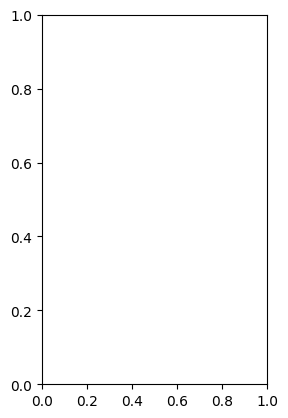

In [15]:
plt.subplot(1, 2, 1)
# set range to [0,1] for matplotlib
plt.imshow(mask[0], vmin=0, vmax=1)
plt.subplot(1, 2, 2)
plt.imshow(pred[0][0].detach().numpy(), vmin=0, vmax=1)